<a href="https://colab.research.google.com/github/Willyzw/monodepth2/blob/master/monodepth2_handson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Tracking the pose of a moving camera and simultanously inferring the **dense** 3D structure of the environment is a long-standing problem which is often denoted as **DenseSLAM**. Traditionally it is approached by two steps, namely a sparse set of feature points along with camera poses is firstly estimated, then followed by multi-view stereo(MVS) to construct the dense scene structure. While this traditional toolchain is well studied consisting of multiple elaborate hand-crafted stages, it lacks robustness in cases such as low texture, thin structure and dynamic objects. Besides that, modern applications like augmented reality or automated driving demand real-time dense scene perceiving for operations like interaction between physical and virtual objects and obstacle avoidance.

With the rapid development and recent advances of deep learning, there has been remarkable progress in this field in recent years. **MonoDepth2**[1] is one of the most representative works. It consists of a depth and a pose network to estimate depth map and camera pose respectively. More specifically, the pose network takes a pair of consecutive images $I_{t-1}$ and $I_t$ and outputs the relative transform from $I_{t-1}$ to $I_t$, while the depth network can map a RGB image $I_{t}$ though an encoder-decoder network to its corresponding depth map. This process can be illustrated as the figure below (Figure 1 of SfMLearner [3])  
![](https://github.com/Willyzw/monodepth2/raw/master/assets/sfmlearner.png)

This notebook aims to convey the MonoDepth2's principles by showing an example. Firstly the required development environment will be set up. Then, a few example images from KITTI dataset[4] are used to illustrated the process of image warping, which is the core principle for the self-supervised learning. At the end, we apply the pre-trained network model on a short video clip of Cityscapes dataset to check how the model generalizes to a different dataset.


# Environment setup

## clone repository
Firstly, the block below will clone the code repository and install needed python packages. In addition, the pre-trained network models, which is trained with both consecutive and stereo images on KITTI dataset, are downloaded from google drive provided by author.

In [3]:
! git clone https://github.com/Willyzw/monodepth2 &> /dev/null
% cd /content/monodepth2/
! pip install -q torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

/content/monodepth2


## Import packages and models

In [21]:
%matplotlib inline
import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
import pandas as pd
import io
import cv2
import yaml

import torch
from torchvision import transforms

import networks
from layers import *

In [7]:
! wget https://storage.googleapis.com/niantic-lon-static/research/monodepth2/mono%2Bstereo_640x192.zip
! unzip -f mono+stereo_640x192.zip -d models
# Path to pre-trained models
depth_encoder_path = os.path.join("models", "encoder.pth")
depth_decoder_path = os.path.join("models", "depth.pth")
pose_encoder_path = os.path.join("models", "pose_encoder.pth")
pose_decoder_path = os.path.join("models", "pose.pth")

# Load depth net model
depth_encoder = networks.ResnetEncoder(18, False).cuda()
depth_decoder = networks.DepthDecoder(num_ch_enc=depth_encoder.num_ch_enc, scales=range(4)).cuda()

loaded_dict_enc = torch.load(depth_encoder_path)
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in depth_encoder.state_dict()}
depth_encoder.load_state_dict(filtered_dict_enc)
depth_decoder.load_state_dict(torch.load(depth_decoder_path))

depth_encoder.eval()
depth_decoder.eval()

# Load pose net pre-trained model
pose_encoder = networks.ResnetEncoder(18, False, 2).cuda()
pose_encoder.load_state_dict(torch.load(pose_encoder_path))

pose_decoder = networks.PoseDecoder(pose_encoder.num_ch_enc, 1, 2).cuda()
pose_decoder.load_state_dict(torch.load(pose_decoder_path))

pose_encoder.eval()
pose_decoder.eval()

feed_width, feed_height = loaded_dict_enc['width'], loaded_dict_enc['height']

--2021-03-12 16:02:52--  https://storage.googleapis.com/niantic-lon-static/research/monodepth2/mono%2Bstereo_640x192.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 172.217.7.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103593905 (99M) [application/zip]
Saving to: ‘mono+stereo_640x192.zip.4’

mono+stereo_640x192 100%[===================>]  98.79M  89.7MB/s    in 1.1s    

2021-03-12 16:02:53 (89.7 MB/s) - ‘mono+stereo_640x192.zip.4’ saved [103593905/103593905]

Archive:  mono+stereo_640x192.zip


# Image warping between target and source images

## Load images

In [8]:
def load_img(path):
  img = pil.open(path).convert('RGB')
  img_resized = img.resize((feed_width, feed_height), pil.LANCZOS)
  img_torch = transforms.ToTensor()(img_resized).unsqueeze(0).cuda()
  return img, img_resized, img_torch

img_target, img_target_resized, img_target_torch = load_img("assets/kitti/0000000069.png")
img_src_prev, img_src_prev_resized, img_src_prev_torch = load_img("assets/kitti/0000000068.png")
img_src_next, img_src_next_resized, img_src_next_torch = load_img("assets/kitti/0000000070.png")
img_src_right, img_src_right_resized, img_src_right_torch = load_img("assets/kitti/0000000069_r.png")

original_width, original_height = img_target.size

## Plot image and predicted depth

Text(0.5, 1.0, 'source right image')

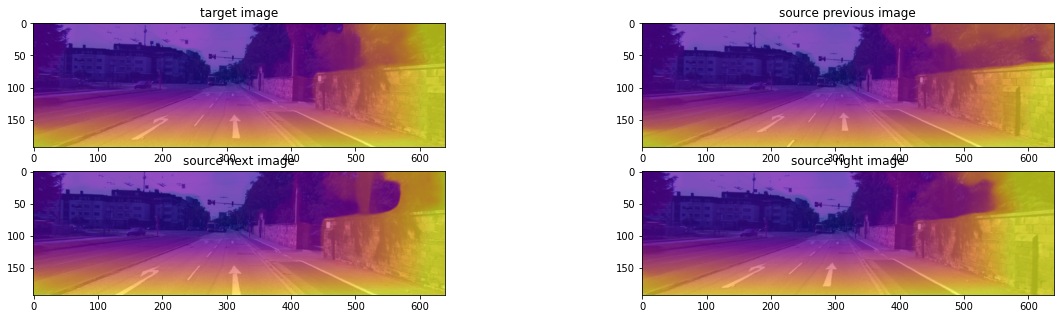

In [38]:
with torch.no_grad():
    depth_features = depth_encoder(torch.cat([img_target_torch, img_src_prev_torch, img_src_next_torch, img_src_right_torch], 0))
    outputs = depth_decoder(depth_features)
    disp_target = outputs[("disp", 0)][0]
    disp_src_prev = outputs[("disp", 0)][1]
    disp_src_next = outputs[("disp", 0)][2]
    disp_src_right = outputs[("disp", 0)][3]

    pose_features = [pose_encoder(torch.cat([
        torch.cat([img_src_prev_torch, img_target_torch], 1),
    ]))]
    axisangle, translation = pose_decoder(pose_features)
    src_prev_T_target = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert=True)

    pose_features = [pose_encoder(torch.cat([
        torch.cat([img_target_torch, img_src_next_torch], 1),
    ]))]
    axisangle, translation = pose_decoder(pose_features)
    src_next_T_target = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert=False)
    torch.cuda.synchronize()

disp_target_np = disp_target.squeeze().cpu().numpy()
vmax = np.percentile(disp_target_np, 95)

plt.figure(figsize=(20, 6))
plt.subplot(221)
plt.imshow(img_target_resized)
plt.imshow(disp_target_np, cmap='plasma', vmax=vmax, alpha=0.7)
plt.title('target image')
plt.subplot(222)
plt.imshow(img_src_prev_resized)
plt.imshow(disp_src_prev.squeeze().cpu().numpy(), cmap='plasma', vmax=vmax, alpha=0.7)
plt.title('source previous image')
plt.subplot(223)
plt.imshow(img_src_next_resized)
plt.imshow(disp_src_next.squeeze().cpu().numpy(), cmap='plasma', vmax=vmax, alpha=0.7)
plt.title('source next image')
plt.subplot(224)
plt.imshow(img_src_right_resized)
plt.imshow(disp_src_right.squeeze().cpu().numpy(), cmap='plasma', vmax=vmax, alpha=0.7)
plt.title('source right image')

## Load kamera intrinsics

In [10]:
with open('assets/kitti/calib_cam_to_cam.txt', 'r') as f:
    calib_cam = yaml.load(f)
K = np.fromstring(calib_cam['P_rect_02'], dtype=np.float32, sep=' ').reshape(3, 4)
K[:, -1] = 0
K = np.concatenate([K, np.array([0, 0, 0, 1]).reshape(1, 4)], axis=0)

# rescale intrinsic matrix based on the ratio between original size and feed size
K[0] *= feed_width/original_width
K[1] *= feed_height/original_height
K_inv = np.linalg.inv(K)

## Warp source images to target frame


[[ 1.   0.   0.  -0.1]
 [ 0.   1.   0.   0. ]
 [ 0.   0.   1.   0. ]
 [ 0.   0.   0.   1. ]]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


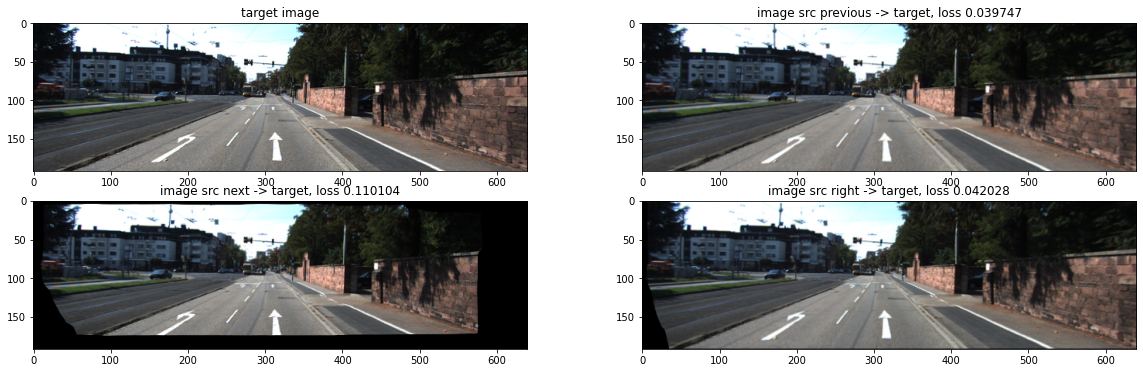

In [30]:
# convert disparity to depth
_, depth_target = disp_to_depth(disp_target, min_depth=0.1, max_depth=100)

backproject_depth = BackprojectDepth(1, feed_height, feed_width).cuda()
project_3d = Project3D(1, feed_height, feed_width).cuda()

stereo_T = np.eye(4, dtype=np.float32)
stereo_T[0, 3] = -0.1
cam_points_target = backproject_depth(depth_target, torch.FloatTensor(K_inv[np.newaxis,:]).cuda())
pix_coords_src_prev = project_3d(cam_points_target, torch.FloatTensor(K[np.newaxis,:]).cuda(), src_prev_T_target)
pix_coords_src_next = project_3d(cam_points_target, torch.FloatTensor(K[np.newaxis,:]).cuda(), src_next_T_target)
pix_coords_src_right = project_3d(cam_points_target, torch.FloatTensor(K[np.newaxis,:]).cuda(), torch.from_numpy(stereo_T).cuda())

with torch.no_grad():
    img_src_prev_warped = F.grid_sample(img_src_prev_torch, pix_coords_src_prev, padding_mode="zeros")
    img_src_next_warped = F.grid_sample(img_src_next_torch, pix_coords_src_next, padding_mode="zeros")
    img_src_right_warped = F.grid_sample(img_src_right_torch, pix_coords_src_right, padding_mode="zeros")

plt.figure(figsize=(20, 6))
plt.subplot(221)
plt.title('target image')
plt.imshow(img_target_resized)
plt.subplot(222)
l1 = torch.abs(img_src_prev_warped-img_target_torch).mean()
plt.title('image src previous -> target, loss %f'%l1)
plt.imshow(img_src_prev_warped.cpu().numpy()[0].transpose(1, 2, 0))
plt.subplot(223)
l1 = torch.abs(img_src_next_warped-img_target_torch).mean()
plt.title('image src next -> target, loss %f'%l1)
plt.imshow(img_src_next_warped.cpu().numpy()[0].transpose(1, 2, 0))
plt.subplot(224)
l1 = torch.abs(img_src_right_warped-img_target_torch).mean()
plt.title('image src right -> target, loss %f'%l1)
plt.imshow(img_src_right_warped.cpu().numpy()[0].transpose(1, 2, 0))

# Apply on Cityscapes

In [64]:
from PIL import Image
from IPython.display import clear_output

cap = cv2.VideoCapture("assets/stuttgart_02.mp4")
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

images = []
while True:
    success, img = cap.read()
    if not success:
        break
    im = Image.fromarray(img[...,::-1])
    # im = im.resize((feed_width, feed_height), pil.LANCZOS)
    # img = transforms.ToTensor()(img).unsqueeze(0).cuda()    
    # images.append(im)

    i += 1
    print('\r', i+1, total_frames, end=' '*10)

print(len(images))

 1579 1200          

KeyboardInterrupt: ignored

# Reference

[1] Godard, C., Aodha, O. Mac, Firman, M., & Brostow, G. (2019). Digging into self-supervised monocular depth estimation. Proceedings of the IEEE International Conference on Computer Vision, 2019-Octob(1), 3827–3837. https://doi.org/10.1109/ICCV.2019.00393 \
[2] kwea123. monodepth2 example. https://gist.github.com/kwea123/3fa35aac268309fc1ccfbe78bb439a28 \
[3] Tinghui Zhou, Matthew Brown, Noah Snavely, D. L. (2017). Unsupervised learning of depth and ego-motion from video. CVPR, 58–65. https://doi.org/10.1109/AIVR46125.2019.00018